In [1]:
# ===================================================================
#  Library
# ===================================================================
import os
import glob
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_percentage_error

import multiprocessing

import warnings
warnings.simplefilter("ignore")

from tqdm.auto import tqdm
import optuna
import unicodedata

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool, metrics

In [2]:
# ===================================================================
#  CFG
# ===================================================================
class CFG:
    filename = "exp012"
    seed = 42
    n_splits = 5
    data_dir = "G:/マイドライブ/signate_StudentCup2023/data/"
    year_bins = 20
    num_boost_round = 10000
    stopping_rounds = 1500
    n_trials = 1500
    save_dir = "G:/マイドライブ/signate_StudentCup2023/exp/"
    num_cores = multiprocessing.cpu_count()
    categorical_features = [
        "fuel", "title_status", "type", "state", "region", "manufacturer", "condition", "cylinders", "transmission", "drive", "size", "paint_color"
        ]

In [3]:
# ===================================================================
#  Utils
# ===================================================================
def seed_everything(seed):
    """fix random factors"""
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
seed_everything(CFG.seed)
    

def get_score(y_true, y_pred):
    """get MAPE score"""
    score = mean_absolute_percentage_error(y_true, y_pred)
    return score * 100

In [4]:
# ===================================================================
#  Data Loading
# ===================================================================
train = pd.read_csv(CFG.data_dir+"train.csv")
test = pd.read_csv(CFG.data_dir+"test.csv")

region_coor = pd.read_csv(CFG.data_dir+"region_coordinate.csv")
state_coor = pd.read_csv(CFG.data_dir+"state_coordinate.csv")

train["flag"] = "train"
test["flag"] = "test"
all_data = pd.concat([train, test], ignore_index=True)

In [5]:
# ===================================================================
#  Utils
# ===================================================================
def seed_everything(seed):
    """fix random factors"""
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
seed_everything(CFG.seed)
    

def get_score(y_true, y_pred):
    """get MAPE score"""
    score = mean_absolute_percentage_error(y_true, y_pred)
    return score * 100


def kfold(CFG, all_data: pd.DataFrame):
    """kfold

    Args:
        CFG : config
        all_data (pd.DataFrame)

    Returns:
        train, test
    """
    train = all_data[all_data["flag"] == "train"].reset_index(drop=True)
    test = all_data[all_data["flag"] == "test"].reset_index(drop=True)
    # priceを小さい順に各foldに振り分ける
    train.sort_values(by="price", ignore_index=True, inplace=True)
    train["fold"] = [i for i in range(CFG.n_splits)] * (train.shape[0] // CFG.n_splits) + [i for i in range(train.shape[0] % CFG.n_splits)]
    train.sort_values(by="id", ignore_index=True, inplace=True)
    print(train["fold"].value_counts())
    print("The variance of the mean of the folds: ", train.groupby("fold")["price"].mean().std())
    return train

In [6]:
# ===================================================================
#  feature_engineering
# ===================================================================
def preprocessing(all_data: pd.DataFrame):
    """
    train, testデータで共通の前処理のコード
    
    ・yearの異常値を直す
    ・manufacturerの表記を統一する
    ・sizeの表記を統一する
    ・regionの欠損値をtrain dataの(state, region)の組み合わせから補完する。残った欠損値は調べて補完する。
    ・title_statusとtypeの欠損値処理はとりあえず放置

    Args:
        all_data (pd.DataFrame): pd.concat([train, test], ignore_index=True)
    """
    # year
    year_dict = {
        2999:1999,
        3008:2008,
        3011:2011,
        3015:2015,
        3017:2017,
        3019:2019,
    }
    all_data["year"] = all_data["year"].replace(year_dict)
    
    
    # manufacturer
    all_data["manufacturer"] = all_data["manufacturer"].str.lower().apply(lambda x: unicodedata.normalize('NFKC', x))
    manufacturer_map = {
        'niѕsan':'nissan',
        'nisѕan':'nissan',
        'subαru':'subaru',
        'toyotа':'toyota',
        'sαturn':'saturn',
        'аcura':'acura',
        'vоlkswagen':'volkswagen',
        'lexuѕ':'lexus',
        'ᴄhrysler':'chrysler',
    }
    all_data["manufacturer"] = all_data["manufacturer"].replace(manufacturer_map)
    
    
    # size
    size_dict = {
        "fullーsize":"full-size",
        "midーsize":"mid-size",
        "subーcompact":"sub-compact",
        "full−size":"full-size",
        "mid−size":"mid-size"
    }
    all_data["size"] = all_data["size"].replace(size_dict)
        
    
    # 地域
    ## region -> stateが一意に定まることを確認
    region_state = {region:{} for region in all_data[all_data["flag"]=="train"]['region'].unique()}
    for row, value in all_data[all_data["flag"]=="train"].iterrows():
        if not pd.isna(value['state']):
            if value['state'] not in region_state[value['region']]:
                region_state[value['region']][value['state']] = 1
            else:
                region_state[value['region']][value['state']] += 1
    for region, state_dict in region_state.items():
        if len(state_dict) > 1 or state_dict == {}:
            region_state[region] = pd.NA
        else:
            region_state[region] = list(state_dict.keys())[0]

    ## regionからstateを決定
    all_data['state'] = [region_state[region] if pd.isna(state) else state for region, state in zip(all_data['region'], all_data['state'])]
    all_data.loc[all_data["region"] == "northwest KS", "state"] = "ks"
    all_data.loc[all_data["region"] == "ashtabula", "state"] = "oh"
    all_data.loc[all_data["region"] == "southern WV", "state"] = "wv"
    
    all_data = pd.merge(all_data, region_coor, on="region", how="left")
    all_data = pd.merge(all_data, state_coor, on="state", how="left")
    
    
    # type
    ## 欠損値 train: 456, test: 229
    
    # title_status
    ## 欠損値 train: 456, test: 229
    
    # fuel
    ## 欠損値 train: 1239, test: 1495
    
    
    all_data["elapsed_years"] = 2023 - all_data["year"]
    all_data["log_elapsed_years"] = np.log(all_data["elapsed_years"])
    all_data["sqrt_elapsed_years"] = np.sqrt(all_data["elapsed_years"])
    
    return all_data

all_data = preprocessing(all_data)

In [7]:
# ===================================================================
#  Cross Validation
# ===================================================================
train = all_data[all_data["flag"] == "train"].reset_index(drop=True)
test = all_data[all_data["flag"] == "test"].reset_index(drop=True)

train.sort_values(by="id", ignore_index=True, inplace=True)

# priceを小さい順に各foldに振り分ける
train.sort_values(by="price", ignore_index=True, inplace=True)
train["fold"] = [i for i in range(CFG.n_splits)] * (train.shape[0] // CFG.n_splits) + [i for i in range(train.shape[0] % CFG.n_splits)]
train.sort_values(by="id", ignore_index=True, inplace=True)
print("The variance of the mean of the folds: ", train.groupby("fold")["price"].mean().std())

The variance of the mean of the folds:  4.695908800203918


In [8]:
def preprocessing_per_fold(CFG, train:pd.DataFrame, fold: int = 0):
    """foldごとの前処理: leakageを防ぐ

    Args:
        CFG :config
        train (pd.DataFrame): 学習データ
        test (pd.DataFrame, optional): test data Defaults to None.
        fold (int, optional): Defaults to 0.
        predict (bool, optional): 予測するか否か. Defaults to False.
    """
    X_train = train[train["fold"] != fold].reset_index(drop=True)
    X_train["price_log"] = np.log(X_train["price"])
    X_valid = train[train["fold"] == fold].reset_index(drop=True)    
    X_valid["price_log"] = np.log(X_valid["price"])

    # odometerの補正
    ## odometerが100以下or400000以上を異常値と考えて補完する
    ## year_mapがodometerの分散が大きくなる特徴量だったのでこれを利用してodometerを補完する
    fillna_map = X_train[(X_train["odometer"] > 100)&(X_train["odometer"] < 400000)].groupby(["region"])["odometer"].mean().reset_index()
    
    def replace_odometer(df: pd.DataFrame, fillna_map: pd.DataFrame)-> pd.DataFrame:
        """odometerの異常値をfillna_mapを利用して補完する

        Args:
            df (pd.DataFrame): 補完前のデータ
            fillna_map (pd.DataFrame): 補完するデータ

        Returns:
            pd.DataFrame: 補完後のデータ
        """
        df_1 = df[(df["odometer"] < 100)|(df["odometer"] > 400000)].reset_index(drop=True)
        df_2 = df[(df["odometer"] >= 100)&(df["odometer"] <= 400000)].reset_index(drop=True)
        df_1.drop("odometer", inplace=True, axis=1)
        df_1 = pd.merge(df_1, fillna_map, on="region", how="left")
        df = pd.concat([df_1, df_2])
        return df.sort_values("id", ignore_index=True)
    
    
    X_train = replace_odometer(X_train, fillna_map)
    X_valid = replace_odometer(X_valid, fillna_map)
    X_train["odometer"].fillna(X_train["odometer"].mean(), inplace=True)
    X_valid["odometer"].fillna(X_train["odometer"].mean(), inplace=True)
        

    # 交互作用
    def apply_fe(df: pd.DataFrame) -> pd.DataFrame:
        """foldごとの特徴量作成

        Args:
            df (pd.DataFrame)

        Returns:
            pd.DataFrame: 特徴量作成後のdf
        """
        df["log_odometer"] = np.log(df["odometer"])
        df["sqrt_odometer"] = np.sqrt(df["odometer"])
        
        df["elapsed_years*odometer"] = df["elapsed_years"] * df["odometer"]
        df["elapsed_years*log_odometer"] = df["elapsed_years"] * df["log_odometer"]
        df["elapsed_years*sqrt_odometer"] = df["elapsed_years"] * df["sqrt_odometer"]
        
        df["log_elapsed_years*odometer"] = df["log_elapsed_years"] * df["odometer"]
        df["log_elapsed_years*log_odometer"] = df["log_elapsed_years"] * df["log_odometer"]
        df["log_elapsed_years*sqrt_odometer"] = df["log_elapsed_years"] * df["sqrt_odometer"]
        
        df["sqrt_elapsed_years*odometer"] = df["sqrt_elapsed_years"] * df["odometer"]
        df["sqrt_elapsed_years*log_odometer"] = df["sqrt_elapsed_years"] * df["log_odometer"]
        df["sqrt_elapsed_years*sqrt_odometer"] = df["sqrt_elapsed_years"] * df["sqrt_odometer"]
        return df
    X_train = apply_fe(X_train)
    X_valid = apply_fe(X_valid)
        
        
    # カウントエンコーディング
    for col in CFG.categorical_features:
        count_map = X_train[col].value_counts().to_dict()
        X_train[col+"_count_encoding"] = X_train[col].map(count_map)
        X_valid[col+"_count_encoding"] = X_valid[col].map(count_map)
        #if fold == 0:
        #    CFG.candidates.append(col+"_count_encoding")
        
        
    # 集約特徴量を用いたエンコーディング
    for col in CFG.categorical_features:
        for agg_ in ["mean", "std", "max", "min", "median"]:
            fillna_map = X_train.groupby(col)["price"].agg(agg_)
            X_train[col+f"_{agg_}_encoding"] = X_train[col].map(fillna_map)
            X_valid[col+f"_{agg_}_encoding"] = X_valid[col].map(fillna_map)
            #if fold == 0:
            #    CFG.candidates.append(col+f"_{agg_}_encoding")
                
    # 集約特徴量を用いたエンコーディング
    for col in CFG.categorical_features:
        for agg_ in ["mean", "std", "max", "min", "median"]:
            fillna_map = X_train.groupby(col)["odometer"].agg(agg_)
            X_train[col+f"_{agg_}_odometer_encoding"] = X_train[col].map(fillna_map)
            X_valid[col+f"_{agg_}_odometer_encoding"] = X_valid[col].map(fillna_map)
            #if fold == 0:
            #    CFG.candidates.append(col+f"_{agg_}_odometer_encoding")
            if agg_ == "median" or agg_ == "mean":
                X_train[col+f"_{agg_}_odometer_encoding_diff"] = X_train[col+f"_{agg_}_odometer_encoding"] - X_train["odometer"]
                X_valid[col+f"_{agg_}_odometer_encoding_diff"] = X_valid[col+f"_{agg_}_odometer_encoding"] - X_valid["odometer"]
                #if fold == 0:
                #    CFG.candidates.append(col+f"_{agg_}_odometer_encoding_diff")
                    
                    
    # 集約特徴量を用いたエンコーディング
    for col in CFG.categorical_features:
        for agg_ in ["mean", "std", "max", "min", "median"]:
            fillna_map = X_train.groupby(col)["elapsed_years"].agg(agg_)
            X_train[col+f"_{agg_}_elapsed_years_encoding"] = X_train[col].map(fillna_map)
            X_valid[col+f"_{agg_}_elapsed_years_encoding"] = X_valid[col].map(fillna_map)
            #if fold == 0:
            #    CFG.candidates.append(col+f"_{agg_}_elapsed_years_encoding")
            if agg_ == "median" or agg_ == "mean":
                X_train[col+f"_{agg_}_elapsed_years_encoding_diff"] = X_train[col+f"_{agg_}_elapsed_years_encoding"] - X_train["elapsed_years"]
                X_valid[col+f"_{agg_}_elapsed_years_encoding_diff"] = X_valid[col+f"_{agg_}_elapsed_years_encoding"] - X_valid["elapsed_years"]
                #if fold == 0:
                #    CFG.candidates.append(col+f"_{agg_}_elapsed_years_encoding_diff")

                
    """
    # target encodingしたやつらの交互作用
    te = [col for col in X_train.columns if "_mean_" in col and "_diff" not in col] 
    for i, col1 in enumerate(tqdm(te)):
        for col2 in te[i:]:
            X_train[f"{col1}*{col2}"] = X_train[col1] * X_train[col2]
            X_valid[f"{col1}*{col2}"] = X_valid[col1] * X_valid[col2]
            if fold == 0:
                CFG.candidates.append(f"{col1}*{col2}")
    """
    """
    # OrdinalEncoder: これはfoldごとではなくともよい
    oe = OrdinalEncoder(categories="auto",
                        handle_unknown="use_encoded_value",
                        unknown_value=999,
                        encoded_missing_value=1000, # QUESTION: 欠損値は-1に変換する -> NaNに??
                        )
    CFG.categorical_features_ = [feature + "_category" for feature in CFG.categorical_features]
    X_train[CFG.categorical_features_] = oe.fit_transform(X_train[CFG.categorical_features].values)
    X_valid[CFG.categorical_features_] = oe.transform(X_valid[CFG.categorical_features].values)
    """
    # CFG.categorical_featuresをcategory型に変換
    for feature in CFG.categorical_features:
        X_train[feature].fillna(-1, inplace=True)
        X_valid[feature].fillna(-1, inplace=True)

        X_train[feature + "_category"] = X_train[feature].astype("category")
        X_valid[feature + "_category"] = X_valid[feature].astype("category")
    return X_train, X_valid

In [9]:
# ===================================================================
#  preprocessing_per_fold
# ===================================================================
X_train0, X_valid0 = preprocessing_per_fold(CFG, train, 0)
X_train1, X_valid1 = preprocessing_per_fold(CFG, train, 1)
X_train2, X_valid2 = preprocessing_per_fold(CFG, train, 2)
X_train3, X_valid3 = preprocessing_per_fold(CFG, train, 3)
X_train4, X_valid4 = preprocessing_per_fold(CFG, train, 4)

In [10]:
# ===================================================================
#  evaluate
# ===================================================================
def train_cat(CFG, cat_param):
    oof_df = pd.DataFrame()
    for fold, (X_train, X_valid) in enumerate(zip([X_train0, X_train1, X_train2, X_train3, X_train4], [X_valid0, X_valid1, X_valid2, X_valid3, X_valid4])):
        # train

        y_train = X_train["price"].values
        X_train = X_train[CFG.use_features]
        id_ = X_valid["id"].values
        y_valid = X_valid["price"].values
        X_valid = X_valid[CFG.use_features]

        # get categorical_features_indices
        cols = X_train.columns.values
        sidx = np.argsort(cols)
        categorical_features = [col for col in CFG.use_features if "_category" in col]
        categorical_features_indices = sidx[np.searchsorted(a=cols, v=categorical_features, sorter=sidx)]
        #print(categorical_features_indices)
        #print(categorical_features)

        # train
        model = CatBoostRegressor(**cat_param)
        train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
        validate_pool = Pool(X_valid, y_valid, cat_features=categorical_features_indices)
        model.fit(train_pool, eval_set=validate_pool)

        # eval
        X_valid[f"pred"] = model.predict(X_valid)
        X_valid["price"] = y_valid
        X_valid["id"] = id_
        print(f"fold{fold}:", get_score(y_true=X_valid["price"], y_pred=X_valid["pred"]))
        # concat
        oof_df = pd.concat([oof_df, X_valid], ignore_index=True)
    score = get_score(oof_df["price"], oof_df["pred"])
    return score, oof_df

In [11]:
CFG.use_features = [
 'title_status_category',
 'type_category',
 'fuel_category',
 'odometer',
 'drive_category',
 'paint_color_category',
 'size_category',
 'year',
 'manufacturer_mean_encoding',
 'condition_mean_encoding',
 'transmission_mean_encoding',
 'region_count_encoding',
 'cylinders_count_encoding',
 'state_count_encoding',
 'cylinders_max_encoding',
 'fuel_std_encoding',
 'manufacturer_median_encoding',
 'condition_median_encoding'
]

In [12]:
# ===================================================================
#  train
# ===================================================================
# params
cat_param = {
    "loss_function":"MAPE",
    "eval_metric": metrics.MAPE(),
    "random_seed": CFG.seed,
    "logging_level": 'Silent',
    "od_type": "Iter",
    "od_wait": CFG.stopping_rounds,
    "use_best_model": True,
    #"task_type": 'GPU' if CFG.device_cat == "cuda" else "CPU"
}

best_score, oof_df = train_cat(CFG, cat_param)
best_score

fold0: 55.93399339838455
fold1: 55.63167853430823
fold2: 56.00917668163983
fold3: 55.95493883442094
fold4: 55.874678619394935


55.880886090482285

<Axes: xlabel='pred', ylabel='Density'>

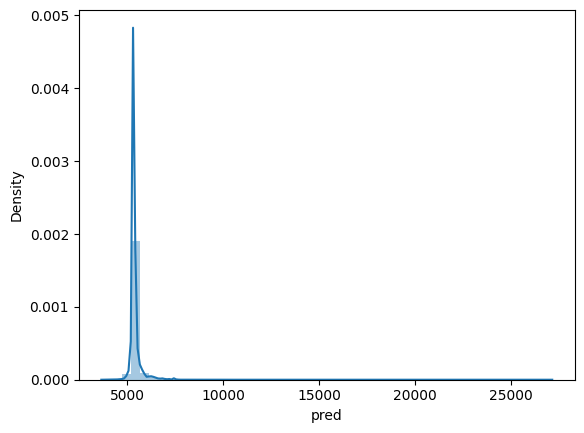

In [15]:
sns.distplot(oof_df["pred"])